<a href="https://colab.research.google.com/github/Jaro1977/Analiza-obrazu-kurs/blob/main/02_document_scanner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import cv2
from google.colab.patches import cv2_imshow
from skimage.filters import threshold_local
import imutils
from numpy.linalg import norm
import cv2

print(cv2.__version__)
import numpy as np


4.7.0


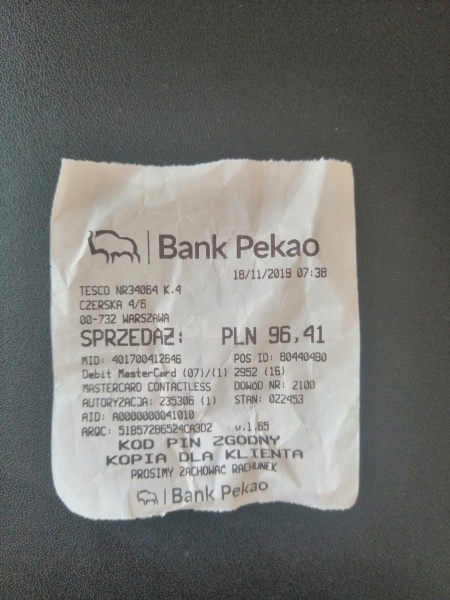

(600, 450, 3)

In [43]:
image = cv2.imread('/content/paragon_1.jpg')
cv2_imshow(image)
image.shape

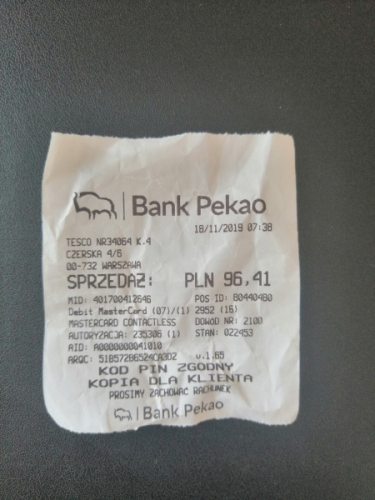

In [44]:
original_image = image.copy()
#zachowamy proporcję originalnego obrazu
ratio = image.shape[0] / 500.0
#zmiana rozmiaru do wysokości 500 pikseli
image = imutils.resize(image, height = 500)
image.shape
cv2_imshow(image)

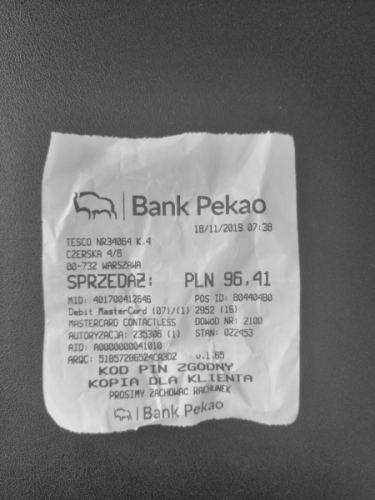

(500, 375)

In [45]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_image)
gray_image.shape

Detekcja krawędzi

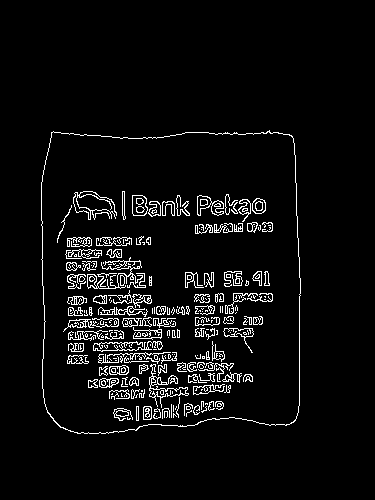

In [46]:
edges = cv2.Canny(gray_image, threshold1 = 75, threshold2 = 200)
cv2_imshow(edges)

Rozmycie

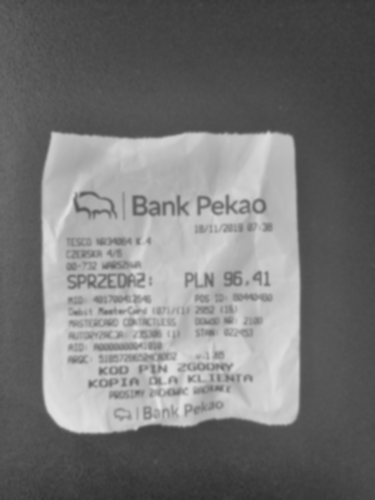

In [47]:
gray_image = cv2.GaussianBlur(gray_image, (5,5), 0)
cv2_imshow(gray_image)

Detekcja krawędzi po rozymciu

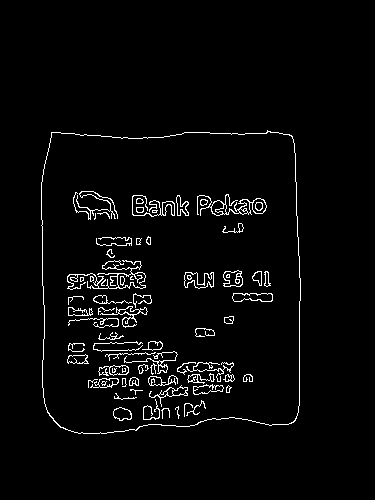

In [48]:
edges = cv2.Canny(gray_image, threshold1 = 75, threshold2 = 200)
cv2_imshow(edges)

Znalezienie konturu dokumentu

In [49]:
contours = cv2.findContours(image = edges.copy(), mode = cv2.RETR_LIST, method = cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
print(f'Liczba wszystkich konturów: {len(contours)}')
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:5]

for contour in contours:
  print(len(contour))

Liczba wszystkich konturów: 135
217
215
189
356
83


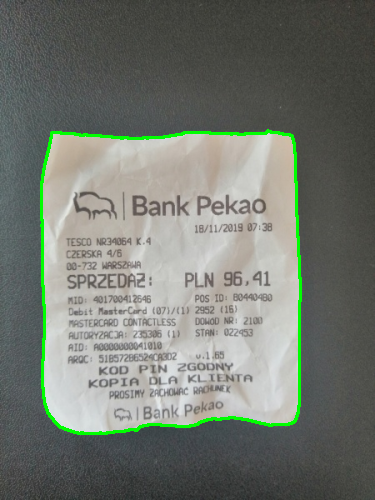

In [50]:
cnt1 = cv2.drawContours(image.copy(), [contours[0]], -1, (0,255,0), 2)
cv2_imshow(cnt1)

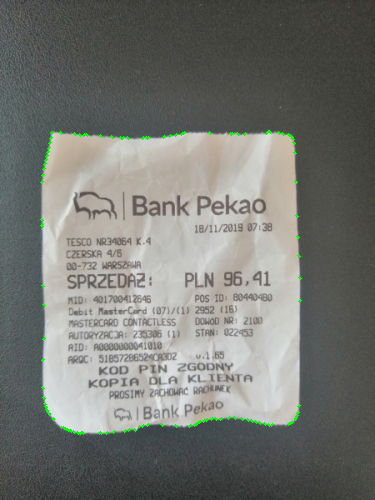

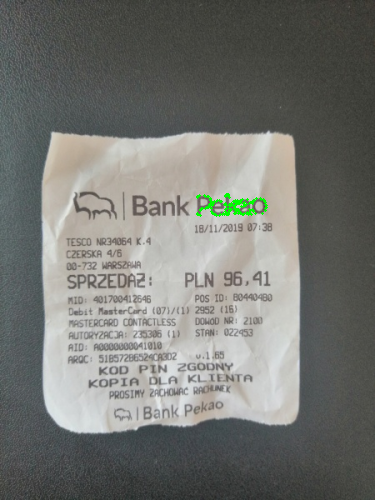

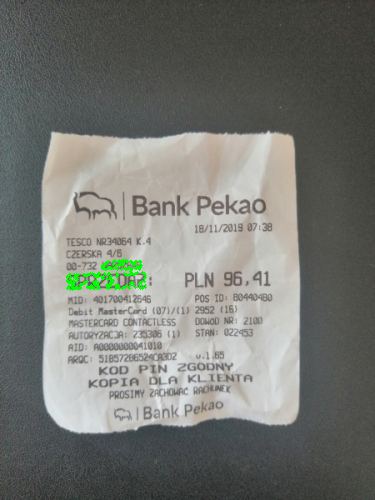

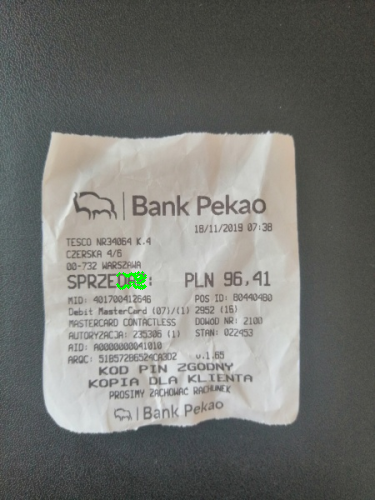

In [51]:
cnt2 = cv2.drawContours(image.copy(), contours[1], -1, (0,255,0), 2)
cv2_imshow(cnt2)
cnt3 = cv2.drawContours(image.copy(), contours[2], -1, (0,255,0), 2)
cv2_imshow(cnt3)
cnt4 = cv2.drawContours(image.copy(), contours[3], -1, (0,255,0), 2)
cv2_imshow(cnt4)
cnt5 = cv2.drawContours(image.copy(), contours[4], -1, (0,255,0), 2)
cv2_imshow(cnt5)

In [52]:
for contour in contours:
  print('Sprawdzenie...')
  #liczymy obwód każdej wyszukanej figury
  perimeter = cv2.arcLength(curve = contour, closed = True)
  #przyblizenie krzywej wielokąta (w naszym przypadku prostokąt) z okresloną pozycją
  approx = cv2.approxPolyDP(curve = contour, epsilon = 0.02 * perimeter, closed = True)

  if len(approx) == 4:
    screen_contour = approx
    break

print(screen_contour)

Sprawdzenie...
[[[291 135]]

 [[ 51 132]]

 [[ 60 427]]

 [[295 420]]]


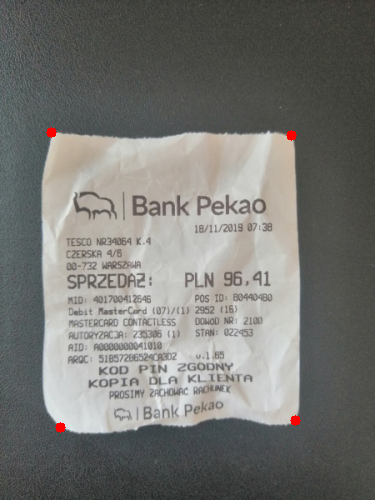

In [53]:
#wyswietlenie znalezionych wierzchołków
cv2.drawContours(image, contours = screen_contour, contourIdx = -1, color = (0,0,255), thickness = 10)
cv2_imshow(image)

Ekstrakcja wierzchołków

In [54]:
points = screen_contour.reshape(4,2)
points = points * ratio
points

array([[349.2, 162. ],
       [ 61.2, 158.4],
       [ 72. , 512.4],
       [354. , 504. ]])

In [55]:
rectangle = np.zeros((4,2), dtype='float32')
rectangle

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [56]:
total = points.sum(axis =1)

rectangle[0] = points[np.argmin(total)]
rectangle[2] = points[np.argmax(total)]
rectangle

array([[ 61.2, 158.4],
       [  0. ,   0. ],
       [354. , 504. ],
       [  0. ,   0. ]], dtype=float32)

In [57]:
difference = np.diff(points, axis =1)
rectangle[1] = points[np.argmin(difference)]
rectangle[3] = points[np.argmax(difference)]
rectangle

array([[ 61.2, 158.4],
       [349.2, 162. ],
       [354. , 504. ],
       [ 72. , 512.4]], dtype=float32)

In [58]:
(a,b,c,d) = rectangle

width1 = norm(c-d)
width2 = norm(b-a)
max_width = max(int(width1), int(width2))

height1 = norm(b-c)
height2 = norm(a-d)
max_height = max(int(height1), int(height2))

print(f'max_width: {max_width}')
print(f'max_height: {max_height}')


max_width: 288
max_height: 354


In [59]:
verticles = np.array([
    [0,0],
    [max_width -1,0],
    [max_width -1, max_height -1],
    [0, max_height-1]
], dtype='float32')

verticles

array([[  0.,   0.],
       [287.,   0.],
       [287., 353.],
       [  0., 353.]], dtype=float32)

Transformacja wyszukanego dokumentu do obrazu: getPerspectiveTransform() - zwraca macierz z transformacji

In [60]:
#macierz transformacji 3x3
M = cv2.getPerspectiveTransform(rectangle, verticles)
M

array([[ 9.47714238e-01, -2.89133112e-02, -5.34202438e+01],
       [-1.20274799e-02,  9.62196799e-01, -1.51675885e+02],
       [-1.16837073e-04, -5.27577240e-05,  1.00000000e+00]])

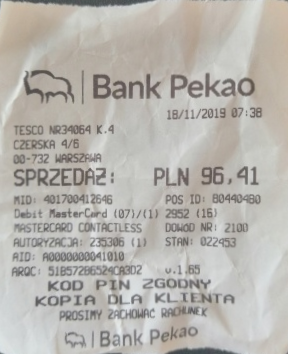

In [61]:
#przekształcenie dokumentu do obrazu
out = cv2.warpPerspective(src = original_image, M=M, dsize = (max_width, max_height))
cv2_imshow(out)

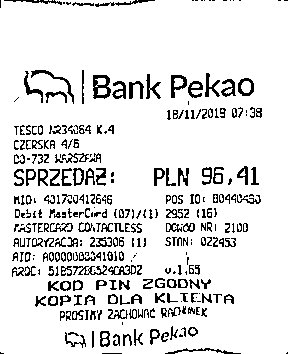

In [62]:
#konwersja do skali szarości
out = cv2.cvtColor(out, cv2.COLOR_BGR2GRAY)

#obliczenie maski progowej na podstawie sąsiedztwa pikseli

T = threshold_local(image = out, block_size = 11, offset =10, method = 'gaussian')
out = (out>T).astype('uint8')*255
cv2_imshow(out)